# Basic regression: Predict fuel efficiency

Taken from [Basic regression: Predict fuel efficiency](https://www.tensorflow.org/tutorials/keras/regression).

## Import the libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import MinMaxScaler, StandardScaler

print(tf.__version__)

2.9.1


## The Auto MPG dataset

### Get the data

In [2]:
# First download and import the dataset using pandas.
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)

In [3]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Clean the data

In [4]:
# The dataset contains a few unknown values.
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [5]:
# Drop those rows to keep this initial tutorial simple.
dataset = dataset.dropna()

In [6]:
# The "Origin" column is categorical, not numeric. One-hot encoding the values in the column.
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


### Split the data into training and test sets

In [7]:
# Split the dataset into a training set and a test set. The test set will be used in the final evaluation of your models.
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

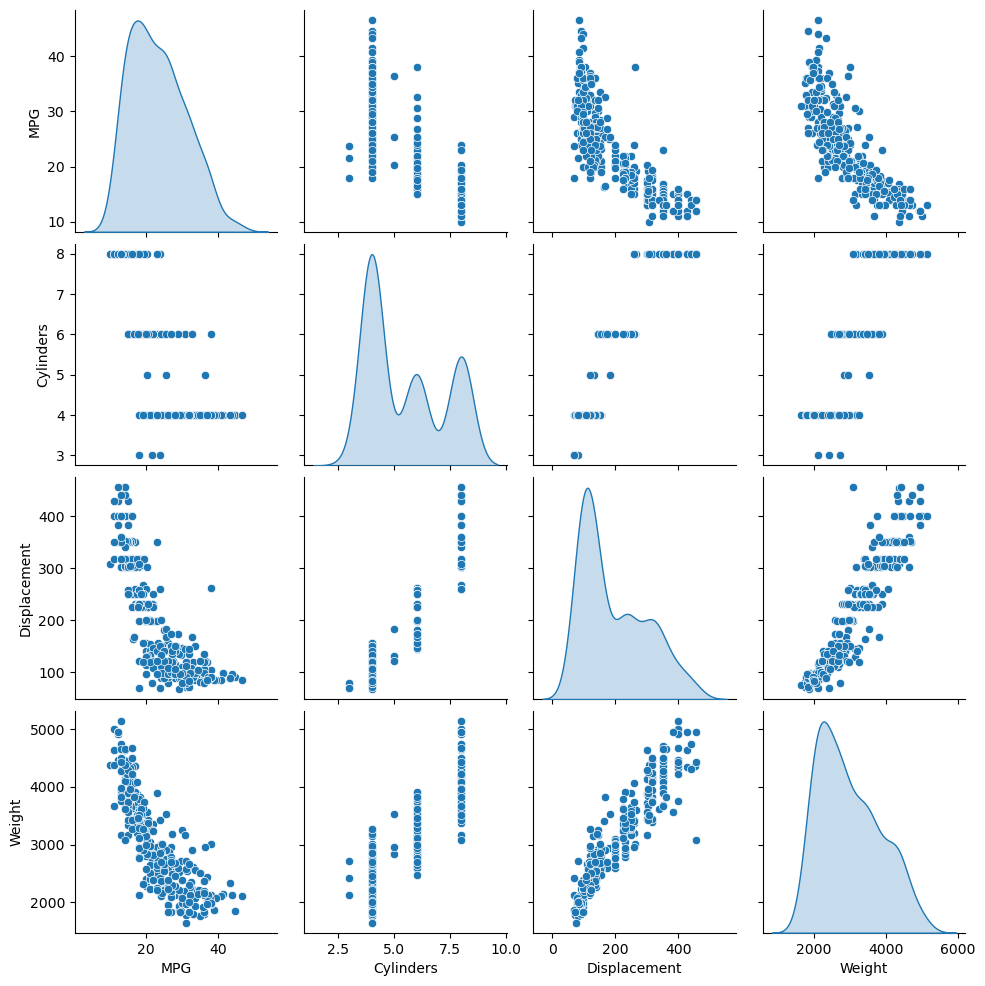

In [8]:
# Review the joint distribution of a few pairs of columns from the training set.
# The top row suggests that the fuel efficiency (MPG) is a function of all the other parameters.
# The other rows indicate they are functions of each other.
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')
plt.show()

In [9]:
# Also check the overll statistics.
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


### Split features from labels

In [10]:
# Separate the target value—the "label"—from the features. The label is the value that you will train the model to predict.
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

## Normalization

In [11]:
# In the table of statistics it's easy to see how different the ranges of each feature are:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


In [12]:
# It is good practice to normalize features that use different scales and ranges.
# One reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and
# the scale of the gradients are affected by the scale of the inputs.
# Although a model might converge without feature normalization, normalization makes training much more stable.

### The Normalization layer

In [13]:
# The tf.keras.layers.Normalization is a clean and simple way to add feature normalization into your model.

In [14]:
# The first step is to create the layer.
normalizer = tf.keras.layers.Normalization(axis=-1)

In [15]:
# Fit the state of the preprocessing layer to the data.
normalizer.adapt(np.array(train_features))

In [16]:
# Calculate the mean and variance, and store them in the layer.
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


In [17]:
# When the layer is called, it returns the input data, with each feature independently normalized.
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


## Linear regression

In [18]:
# Before building a deep neural network model, start with linear regression using one and several variables.

### Linear regression with one variable

#### Linear regression with Horsepower

In [19]:
# Create a NumPy array made of the 'Horsepower' features.
horsepower = np.array(train_features['Horsepower'])

# Instantiate the tf.keras.layers.Normalization.
horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)

# Fit its state to the horsepower data
horsepower_normalizer.adapt(horsepower)

In [20]:
# Build the Keras Sequential model.
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [21]:
# This model will predict 'MPG' from 'Horsepower'.

# Run the untrained model on the first 10 'Horsepower' values. The output won't be good,
# but notice that it has the expected shape of (10, 1):
horsepower_model.predict(horsepower[:10])

1/1 [==============================] - 0s 123ms/step


array([[ 0.183],
       [ 0.103],
       [-0.338],
       [ 0.256],
       [ 0.232],
       [ 0.091],
       [ 0.275],
       [ 0.232],
       [ 0.06 ],
       [ 0.103]], dtype=float32)

In [22]:
# Configure the training procedure using the Keras Model.compile method.
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [23]:
%%time
# Use Keras Model.fit to execute the training for 100 epochs
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Wall time: 6.66 s


In [24]:
# Visualize the model's training progress using the stats stored in the history object
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.801567,4.180593,95
96,3.802859,4.180346,96
97,3.803695,4.187755,97
98,3.805889,4.188438,98
99,3.802987,4.192620,99


In [25]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

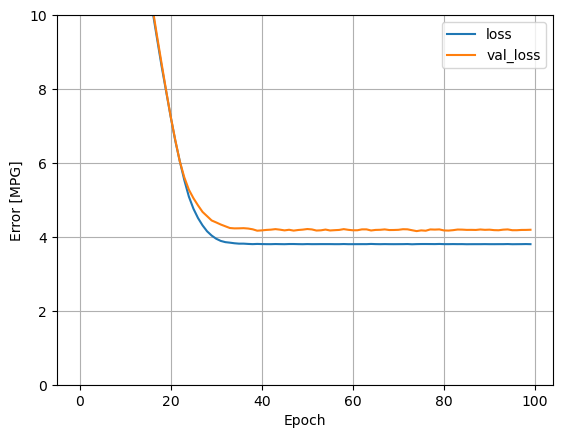

In [26]:
plot_loss(history)
plt.show()

In [27]:
# Collect the results on the test set for later.
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

In [28]:
# Since this is a single variable regression, it's easy to view the model's predictions as a function of the input.
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

8/8 [==============================] - 0s 3ms/step


In [29]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

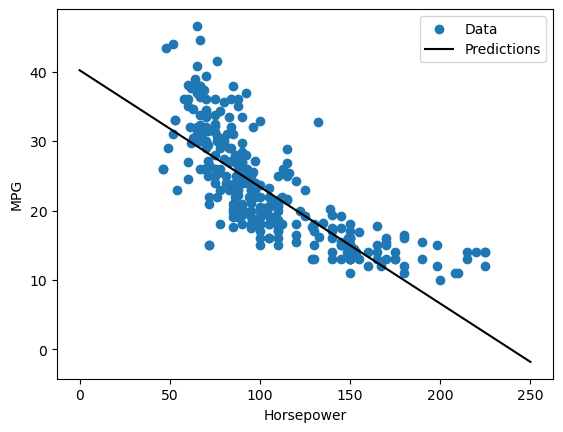

In [30]:
plot_horsepower(x, y)
plt.show()

### Linear regression with multiple inputs

In [31]:
# Create a two-step Keras Sequential model again with the first layer being normalizer (tf.keras.layers.Normalization(axis=-1))
# defined earlier and adapted to the whole dataset.
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [32]:
# When Model.predict is called on a batch of inputs, it produces units=1 outputs for each example.
linear_model.predict(train_features[:10])

1/1 [==============================] - 0s 63ms/step


array([[ 1.259],
       [ 0.171],
       [ 0.777],
       [-0.212],
       [-1.171],
       [ 0.275],
       [-1.146],
       [-0.941],
       [ 1.144],
       [-0.093]], dtype=float32)

In [33]:
# When the model is called, its weight matrices will be built—check that the kernel weights (the  in ) have a shape of (9, 1).
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[ 0.269],
       [-0.681],
       [-0.653],
       [ 0.586],
       [-0.085],
       [-0.721],
       [-0.472],
       [-0.45 ],
       [ 0.057]], dtype=float32)>

In [34]:
# Configure the model with Keras Model.compile and train with Model.fit for 100 epochs.
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [35]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Wall time: 6.51 s


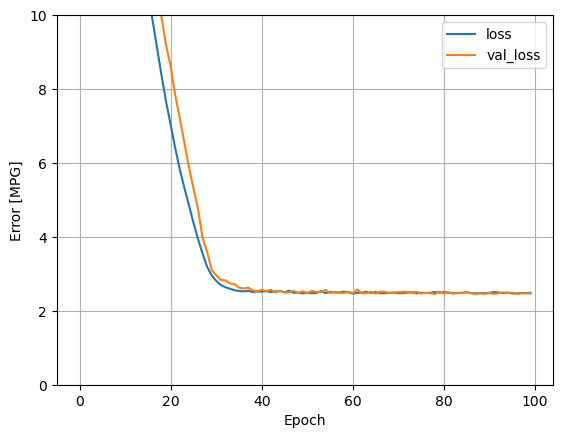

In [36]:
# Using all the inputs in this regression model achieves a much lower training and validation error than the horsepower_model,
# which had one input.
plot_loss(history)
plt.show()

In [37]:
# Collect the results on the test set for later.
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

## Regression with a deep neural network (DNN)

In [38]:
# It will be used the same training procedure, so the compile method is included in the build_and_compile_model function below.
def build_and_compile_model(norm):
    model = keras.Sequential([
    norm,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
    optimizer=tf.keras.optimizers.Adam(0.001))
    return model

### Regression using a DNN and a single input

In [39]:
# Create a DNN model with only 'Horsepower' as input and horsepower_normalizer (defined earlier) as the normalization layer.
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [40]:
# This model has quite a few more trainable parameters than the linear models.
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [41]:
%%time
# Train the model with Keras Model.fit.
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 4.35 s


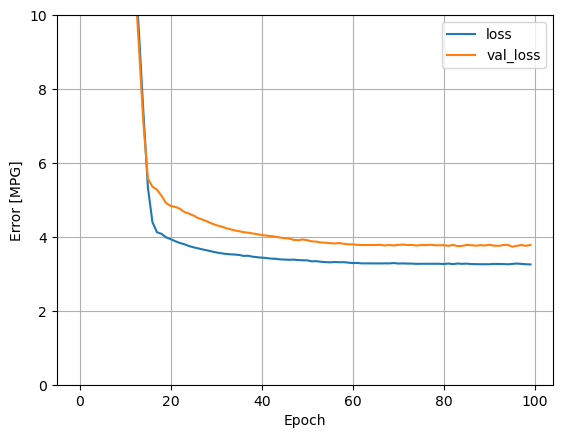

In [42]:
# This model does slightly better than the linear single-input horsepower_model.
plot_loss(history)
plt.show()

In [43]:
# If it is plotted the predictions as a function of 'Horsepower', it should be noticed how this model takes advantage of the
# nonlinearity provided by the hidden layers.
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

8/8 [==============================] - 0s 3ms/step


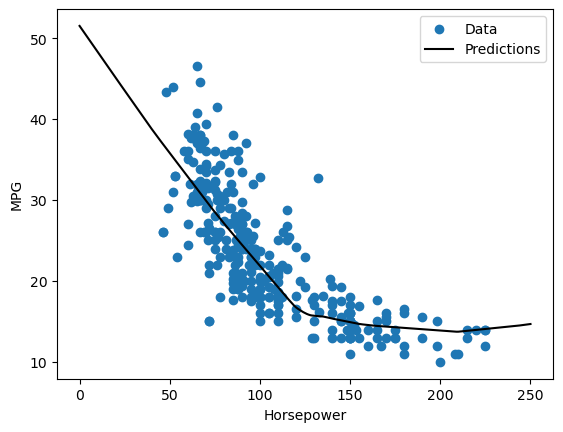

In [44]:
plot_horsepower(x, y)
plt.show()

In [45]:
# Collect the results on the test set for later.
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

### Regression using a DNN and multiple inputs

In [46]:
# Repeat the previous process using all the inputs. The model's performance slightly improves on the validation dataset.
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                640       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [47]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 4.35 s


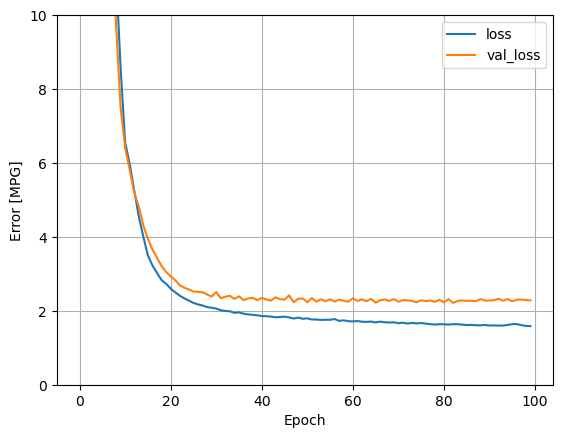

In [48]:
plot_loss(history)
plt.show()

In [49]:
# Collect the results on the test set.
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

### Performance

In [50]:
# Since all models have been trained, it can be reviewed their test set performance.
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.643701
linear_model,2.456442
dnn_horsepower_model,2.976837
dnn_model,1.683412


In [51]:
# The above results match the validation error observed during training.

### Make predictions

3/3 [==============================] - 0s 10ms/step


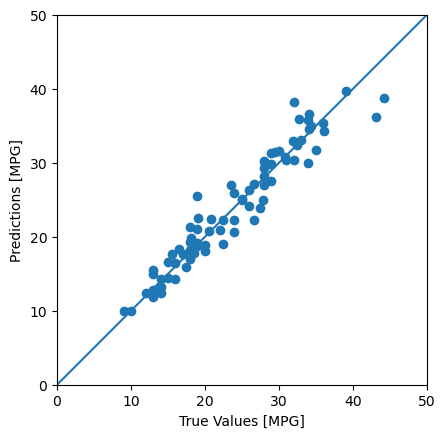

In [52]:
# Now make predictions with the dnn_model on the test set using Keras Model.predict and review the loss.
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.show()

In [53]:
# It appears that the model predicts reasonably well.

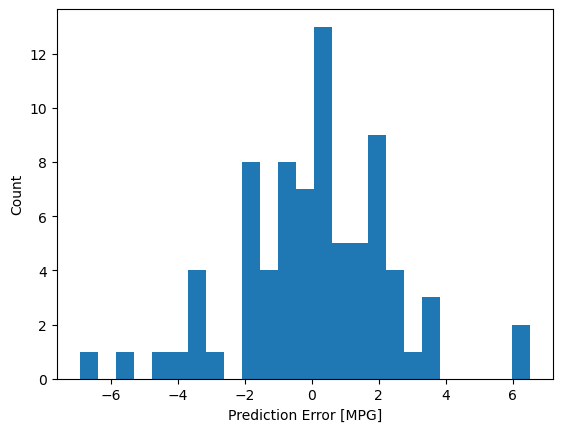

In [54]:
# Check the error distribution.
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')
plt.show()

In [55]:
# If the model is satisfactory, save it for later use with Model.save.
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model\assets


In [56]:
# If the model is reloaded, it gives identical output.
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [57]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.643701
linear_model,2.456442
dnn_horsepower_model,2.976837
dnn_model,1.683412
reloaded,1.683412
